In [62]:
from __future__ import absolute_import, division, print_function, unicode_literals

from shapely.geometry import LineString, Point, Polygon
from sympy import RegularPolygon

import pathlib
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [63]:
def angle3d(x1,y1,z1,x2,y2,z2,x3,y3,z3):
    a = np.array([x1,y1,z1])
    b = np.array([x2,y2,z2])
    c = np.array([x3,y3,z3])
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.pi - np.arccos(cosine_angle)
    return (angle)


def errorangle3d(angle, energy2, fwhm_en_perc):
    energyerr = fwhm_en_perc*energy2/2.355
    return abs(0.511*energyerr/(np.sin(angle)*((0.511-energy2)**2)))

def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame



def build_model():
    model = keras.Sequential([layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(5, activation=tf.nn.relu),
    #layers.Dense(5, activation=tf.nn.tanh),
    layers.Dense(2, activation=tf.nn.softmax)])

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],
           label='Acc')
    plt.legend()
    plt.show()
    
#geometry of scanner needed for first intersection
r_min = 50.1
m_width = 13
r_eff = np.sqrt(r_min**2+(m_width/2)**2)
n_repeat = 24
poly = RegularPolygon([0, 0], r_eff, n_repeat, np.pi/(n_repeat))
polyscipy = Polygon(poly.vertices)

#TO CHECK 
def find_intersection(point1, point2, x1, x2): #point 1 is the single event, point 2 is the first candidate for compton event
    #use midpoint, else i find two intersections
    midpoint = [(point1[0]+point2[0])/2, (point1[1]+point2[1])/2]
    line = LineString([midpoint,point2])
    inters = polyscipy.intersection(line)
    #placeholder for when it does not intersect (need to investigate)
    intersection = -1
    
    if inters:
        y, z = inters.xy
        y1 = y[0]; z1 = z[0]
        y2 = y[1]; z2 = z[1]

        #intersection are the midpoint and the true intersection
        if y1 == midpoint[0] and z1 == midpoint[1]: #then y2,z2 is the true intersection
            x2int = find_x_inline(x1,point1[0],x2,point2[0],y2) #find x coordinate of intersection
            intersection = [x2int, y2, z2]
        elif y2 == midpoint[0] and z2 == midpoint[1]: #then y1,z1 is the true intersection
            x1int = find_x_inline(x2, point2[0], x1, point1[0],y1) #find x coordinate of intersection
            intersection = [x1int, y1, z1]
    return intersection

def find_x_inline(x1,y1,x2,y2,y3): #1 is single (point1), 2 is compton (point2), 3 is intersection
    return ((x2-x1)/(y2-y1)*(y3-y1) + x1)
    
def distance_travelled(x1,y1,z1,x2,y2,z2):
    return(np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2))
    

In [64]:
dataset_path = '/home/pipsini/Documents/CERN/PET/programs/PET-Coincidences-Compton/macro/build/test_compton_big.txt'
#dataset_path = '/home/pipsini/Documents/CERN/PET/programs/PET-Coincidences-Compton/macro/build/test_compton_small.txt'
#dataset_path = '/home/pipsini/Documents/CERN/PET/programs/PET-Coincidences-Compton/macro/build/test_compton.txt'

raw_dataset = pd.read_csv(dataset_path, sep="\t", usecols=range(0,18))
dataset = raw_dataset.copy()

angle = []
anglewrong = []
angle_smeared = []
anglewrong_smeared = []
en2_smeared = []
en3_smeared = []
x1_smeared = []
y1_smeared = []
z1_smeared = []
x2_smeared = []
y2_smeared = []
z2_smeared = []
x3_smeared = []
y3_smeared = []
z3_smeared = []
distance_trav = []
distance_trav_smeared = []
distance_trav_wrong = []
distance_trav_wrong_smeared = []

fwhm_doi = 3
fwhm_en_perc = 0.1
cry_side = 1.53

debuggging = []
debuggging2 = []


for index, row in dataset.iterrows():
    #coordinates with smearing
    #doi smearing
    x1sm = np.random.normal(row['x1'], 3/2.355)
    x2sm = np.random.normal(row['x2'], 3/2.355)
    x3sm = np.random.normal(row['x3'], 3/2.355)
    x1_smeared.append(x1sm)
    x2_smeared.append(x2sm)
    x3_smeared.append(x3sm)
    #crystals smearing #TODO: crystal centers
    y1sm = np.random.uniform(row['y1']-cry_side/2, row['y1']+cry_side/2)
    y2sm = np.random.uniform(row['y2']-cry_side/2, row['y2']+cry_side/2)
    y3sm = np.random.uniform(row['y3']-cry_side/2, row['y3']+cry_side/2)
    y1_smeared.append(y1sm)
    y2_smeared.append(y1sm)
    y3_smeared.append(y1sm)
    z1sm = np.random.uniform(row['z1']-cry_side/2, row['z1']+cry_side/2)
    z2sm = np.random.uniform(row['z2']-cry_side/2, row['z2']+cry_side/2)
    z3sm = np.random.uniform(row['z3']-cry_side/2, row['z3']+cry_side/2)
    z1_smeared.append(z1sm)
    z2_smeared.append(z1sm)
    z3_smeared.append(z1sm)

    #energy with smearing 
    en2_smeared_value = np.random.normal(row['energy2'], fwhm_en_perc*row['energy2']/2.355)
    en3_smeared_value = np.random.normal(row['energy3'], fwhm_en_perc*row['energy3']/2.355)
    en2_smeared.append(en2_smeared_value)
    en3_smeared.append(en3_smeared_value)

    #angle with no smearing
    angle.append(angle3d(row['x1'],row['y1'],row['z1'],row['x2'],row['y2'],row['z2'],row['x3'],row['y3'],row['z3']))          
    anglewrong.append(angle3d(row['x1'],row['y1'],row['z1'],row['x3'],row['y3'],row['z3'],row['x2'],row['y2'],row['z2']))  
    #angle with smearing
    angle_smeared.append(angle3d(x1sm,y1sm,z1sm,x2sm,y2sm,z2sm,x3sm,y3sm,z3sm))            
    anglewrong_smeared.append(angle3d(x1sm,y1sm,z1sm,x3sm,y3sm,z3sm,x2sm,y2sm,z2sm))

    #distance travelled with no smearing
    interspoint = find_intersection([row['y1'],row['z1']],[row['y2'],row['z2']], row['x1'], row['x2'])
    if interspoint != -1:
        distance_trav_value = distance_travelled(interspoint[0], interspoint[1], interspoint[2], row['x2'],row['y2'],row['z2']) 
    else:
        distance_trav_value = np.NaN
    interspointwrong = find_intersection([row['y1'],row['z1']],[row['y3'],row['z3']], row['x1'], row['x3'])
    if interspointwrong != -1:
        distance_trav_wrong_value = distance_travelled(interspoint[0], interspoint[1], interspoint[2], row['x3'],row['y3'],row['z3']) 
    else:
        distance_trav_wrong_value = np.NaN
        

    distance_trav.append(distance_trav_value)
    distance_trav_wrong.append(distance_trav_wrong_value)

    #distance travelled with smearing
    interspoint = find_intersection([y1sm, z1sm],[y2sm, z2sm], x1sm,x2sm)
    if interspoint != -1:
        distance_trav_value_smeared = distance_travelled(interspoint[0], interspoint[1], interspoint[2], x2sm, y2sm, z2sm) 
    else:
        distance_trav_value_smeared = np.NaN
    interspointwrong = find_intersection([y1sm, z1sm],[y3sm, z3sm], x1sm,x3sm)
    if interspointwrong != -1:
        distance_trav_wrong_value_smeared = distance_travelled(interspoint[0], interspoint[1], interspoint[2], x3sm, y3sm, z3sm) 
    else:
        distance_trav_wrong_value_smeared = np.NaN

    distance_trav_smeared.append(distance_trav_value_smeared)
    distance_trav_wrong_smeared.append(distance_trav_wrong_value_smeared)
    
    
    debuggging.append(distance_travelled(row['x2'],row['y2'],row['z2'], row['x3'],row['y3'],row['z3']))
    debuggging2.append(distance_travelled(row['x1'],row['y1'],row['z1'], row['x2'],row['y2'],row['z2']))

print(len(x1_smeared))
print(len(distance_trav))

#fill the dataframe
dataset['x1_smeared'] = x1_smeared
dataset['y1_smeared'] = y1_smeared
dataset['z1_smeared'] = z1_smeared
dataset['x2_smeared'] = x2_smeared
dataset['y2_smeared'] = y2_smeared
dataset['z2_smeared'] = z2_smeared
dataset['x3_smeared'] = x3_smeared
dataset['y3_smeared'] = y3_smeared
dataset['z3_smeared'] = z3_smeared

dataset['compt_angle'] = angle
dataset['compt_angle_wrong'] = anglewrong
dataset['compt_angle_smeared'] = angle_smeared
dataset['compt_angle_wrong_smeared'] = anglewrong_smeared
dataset['energy2_smeared'] = en2_smeared
dataset['energy3_smeared'] = en3_smeared

dataset['dist'] = distance_trav
dataset['dist_wrong'] = distance_trav_wrong
dataset['dist_smeared'] = distance_trav_smeared
dataset['dist_wrong_smeared'] = distance_trav_wrong_smeared



/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


124877
124877


In [65]:
#remove not a number angles (same position of compton) #how is this possible??
print(dataset.isna().sum())
dataset = dataset.dropna()
dataset.head()

xs1                            0
ys1                            0
zs1                            0
x1                             0
y1                             0
z1                             0
x2                             0
y2                             0
z2                             0
x3                             0
y3                             0
z3                             0
time1                          0
time2                          0
time3                          0
energy1                        0
energy2                        0
energy3                        0
x1_smeared                     0
y1_smeared                     0
z1_smeared                     0
x2_smeared                     0
y2_smeared                     0
z2_smeared                     0
x3_smeared                     0
y3_smeared                     0
z3_smeared                     0
compt_angle                    1
compt_angle_wrong              1
compt_angle_smeared            0
compt_angl

,xs1,ys1,zs1,x1,y1,z1,x2,y2,z2,x3,...,compt_angle,compt_angle_wrong,compt_angle_smeared,compt_angle_wrong_smeared,energy2_smeared,energy3_smeared,dist,dist_wrong,dist_smeared,dist_wrong_smeared
0,0.08,19.95,0.03,2.9,44.2,24.5,-5.1,-24.6,-44.8,-0.1,...,1.471937,1.727773,1.430297,1.771831,0.267443,0.259170,1.048377,5.957474,0.829644,6.274181
1,-0.10,20.10,0.03,-2.7,-2.1,-50.2,1.7,37.2,38.7,-2.7,...,1.426182,1.782252,1.434147,1.772650,0.240591,0.275823,3.844371,8.143957,4.242656,8.286319
2,0.07,20.12,0.01,2.1,57.8,-26.6,-3.3,-38.2,41.2,0.2,...,1.162680,2.024373,0.895348,2.283032,0.187428,0.273821,6.152171,10.113157,5.459422,10.082235
3,-0.11,19.97,0.01,2.2,9.4,57.0,-2.0,28.4,-45.4,2.1,...,1.068812,2.124336,1.093682,2.101102,0.128555,0.403147,3.641262,8.674942,3.022823,8.220557
4,0.05,19.95,-0.13,-1.2,52.1,8.2,2.9,-52.2,-18.8,-1.3,...,2.099311,1.109249,1.955746,1.259221,0.291442,0.207248,5.203385,7.051259,4.676145,7.864133


In [66]:
smearing = True


if smearing == False:
    variables = ['energy2', 'energy3','compt_angle','compt_angle_wrong', 'dist', 'dist_wrong']
else:
    variables = ['energy2_smeared', 'energy3_smeared','compt_angle_smeared','compt_angle_wrong_smeared','dist_smeared', 'dist_wrong_smeared']
    
dataset_preparing = select_columns(dataset, variables)

df1 = dataset_preparing.iloc[:(len(dataset_preparing)//2),:]
df1['label'] = [1]*len(df1)

df2 = dataset_preparing.iloc[(len(dataset_preparing)//2):,:]
col_list = list(df2)
col_list[0], col_list[1], col_list[2], col_list[3],  col_list[4], col_list[5] = col_list[1], col_list[0], col_list[3], col_list[2],  col_list[5], col_list[4] 
df2.columns = col_list
df2 = df2[[col_list[1], col_list[0], col_list[3], col_list[2],  col_list[4], col_list[5] ]]
df2['label'] = [0]*len(df2)

MLdataset = df1.append(df2)

MLdataset



/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,compt_angle_smeared,compt_angle_wrong_smeared,dist_smeared,dist_wrong_smeared,energy2_smeared,energy3_smeared,label
0,1.430297,1.771831,0.829644,6.274181e+00,0.267443,0.259170,1
1,1.434147,1.772650,4.242656,8.286319e+00,0.240591,0.275823,1
2,0.895348,2.283032,5.459422,1.008223e+01,0.187428,0.273821,1
3,1.093682,2.101102,3.022823,8.220557e+00,0.128555,0.403147,1
4,1.955746,1.259221,4.676145,7.864133e+00,0.291442,0.207248,1
5,1.048372,2.115295,7.349778,9.236758e+00,0.308329,0.214484,1
6,1.424817,1.745799,9.778912,1.076927e+01,0.240527,0.273247,1
7,2.748533,0.418317,9.119983,3.953007e+00,0.309042,0.181232,1
8,1.947463,1.228979,6.374511,6.112712e+00,0.318514,0.214110,1
9,2.205101,0.958761,2.417440,2.353130e+00,0.285235,0.215083,1


In [67]:
#split train and test
MLdataset = shuffle(MLdataset)

train_dataset = MLdataset.sample(frac=0.8,random_state=0)
test_dataset = MLdataset.drop(train_dataset.index)

train_labels = train_dataset.pop('label')
test_labels = test_dataset.pop('label')



In [68]:
model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 5)                 35        
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 12        
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


In [69]:
EPOCHS=50

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(train_dataset, train_labels, epochs=EPOCHS, callbacks=[early_stop])


Epoch 1/50
99583/99583 [==============================] - 3s 25us/sample - loss: 0.3270 - acc: 0.8708
Epoch 2/50
99583/99583 [==============================] - 2s 22us/sample - loss: 0.2736 - acc: 0.8967
Epoch 3/50
99583/99583 [==============================] - 2s 20us/sample - loss: 0.2670 - acc: 0.8985
Epoch 4/50
99583/99583 [==============================] - 3s 25us/sample - loss: 0.2571 - acc: 0.9000
Epoch 5/50
99583/99583 [==============================] - 2s 22us/sample - loss: 0.2467 - acc: 0.9017
Epoch 6/50
99583/99583 [==============================] - 2s 22us/sample - loss: 0.2366 - acc: 0.9028
Epoch 7/50
99583/99583 [==============================] - 2s 24us/sample - loss: 0.2298 - acc: 0.9051
Epoch 8/50
99583/99583 [==============================] - 3s 27us/sample - loss: 0.2246 - acc: 0.9064
Epoch 9/50
99583/99583 [==============================] - 3s 26us/sample - loss: 0.2194 - acc: 0.9080
Epoch 10/50
99583/99583 [==============================] - 2s 23us/sample - loss: 

In [70]:
#Let's see how well the model generalizes by using the test set, which we 
#did not use when training the model. This tells us how well we can expect the 
#model to predict when we use it in the real world.
test_loss, test_acc = model.evaluate(test_dataset, test_labels)
print('Test accuracy:', test_acc)


24896/24896 [==============================] - 0s 15us/sample - loss: 0.1810 - acc: 0.91390s - loss: 0.1818 - acc: 0.913
Test accuracy: 0.9138817


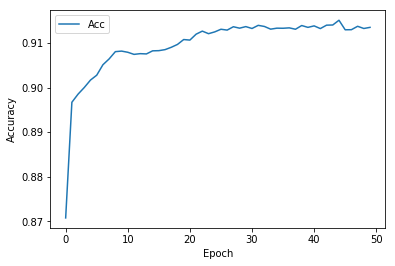

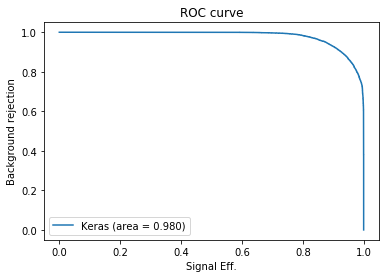

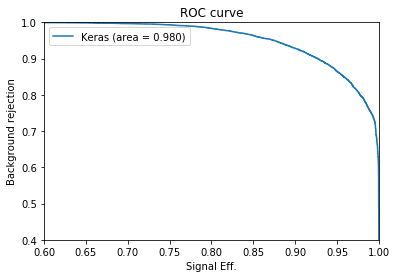

In [71]:
##### plot accuracy history
plot_history(history)

# Plot ROC curve
y_pred_keras = model.predict(test_dataset)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred_keras[:,1])
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
#plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tpr_keras, 1-fpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('Signal Eff.')
plt.ylabel('Background rejection')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
#plt.plot([0.6, 1], [0.95, 1], 'k--')
plt.plot(tpr_keras, 1-fpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('Signal Eff.')
plt.ylabel('Background rejection')
plt.xlim(0.6, 1)
plt.ylim(0.4, 1)
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()